I want to make a prediction!

I found some great leads on ML for time-series prediction here:

http://machinelearningmastery.com/promise-recurrent-neural-networks-time-series-forecasting/

http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

I'll try to use the Long Short-Term Memory (LSTM) Recurrent Neural Network for this prediction.



These tutorials use a simple dataset to perform a straigh-forward prediction. I will break down our problem into several steps, each increasing the complication of the problem:

1. Predict a player's goal scoring based on their past few season's stats - use games played & goals.
2. Predict a player's goal scoring based on their past few season's stats - use many stat categories
3. Predict a player's performance in a number of stat categories based on their recent performance.
4. Predict a player's goal scoring based on many players' past few seasons' performance.


I think I'll start with Ovi's stats. I know he has a number of years in the league and I know his player ID.



Copying from 

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

and modified for ML4NHL




Set up the workspace:

In [37]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
#from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Define a function to alter a series for ML problems

In [2]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

Define some more functions:

In [3]:
# create a differenced series
#def difference(dataset, interval=1):
#	diff = list()
#	for i in range(interval, len(dataset)):
#		value = dataset[i] - dataset[i - interval]
#		diff.append(value)
#	return Series(diff)
 
# invert differenced value
#def inverse_difference(history, yhat, interval=1):
#	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

Functions defined!

Let's try to apply this....

In [4]:
# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

statspd=read_csv('NHL_skater_stats_2011-2016.csv')#,header=None)

Okay, first we'll just need a single player's GP, goals, PIMs. Extract from the stats dataframe.

We're going to analyze Alex Ovechkin, whose player id is 8471214. 

In [5]:
OVIstats = statspd.drop(statspd.index[statspd.PlayerId != 8471214])

OVIstats

,﻿Season,Assists,FaceoffWinPctg,GameWinningGoals,GamesPlayed,Goals,OTGoals,PenaltyMinutes,PlayerFirstName,PlayerId,...,Points,PPGoals,PPPoints,SHGoals,SHPoints,ShiftsPerGame,ShootingPctg,Shots,TeamAbbrev,TimeOnIcePerGame
2,20112012,31,0.4375,4,92,43,2,34,Alex,8471214,...,74,15,27,0,0,21.4782,0.1218,353,NaN,1188.4891
1235,20122013,25,0.0000,4,55,33,0,40,Alex,8471214,...,58,17,29,0,0,21.3818,0.1320,250,NaN,1251.9454
2495,20132014,28,0.6666,10,78,51,3,48,Alex,8471214,...,79,24,39,0,1,21.7948,0.1321,386,NaN,1232.7179
3144,20142015,32,0.5000,11,95,58,0,64,Alex,8471214,...,90,26,36,0,0,22.8105,0.1271,456,NaN,1216.2526
4126,20152016,28,0.0000,9,91,55,2,55,Alex,8471214,...,83,22,31,0,0,22.0000,0.1195,460,NaN,1226.5384


In [6]:
print(OVIstats.columns)

Index(['﻿Season', 'Assists', 'FaceoffWinPctg', 'GameWinningGoals',
       'GamesPlayed', 'Goals', 'OTGoals', 'PenaltyMinutes', 'PlayerFirstName',
       'PlayerId', 'PlayerLastName', 'PlayerName', 'PlayerPositionCode',
       'PlusMinus', 'Points', 'PPGoals', 'PPPoints', 'SHGoals', 'SHPoints',
       'ShiftsPerGame', 'ShootingPctg', 'Shots', 'TeamAbbrev',
       'TimeOnIcePerGame'],
      dtype='object')


Okay, let's pare this down to only the stats we need...

In [7]:
OVIstats.drop(['﻿Season', 'FaceoffWinPctg', 'GameWinningGoals','GamesPlayed', 'PenaltyMinutes', 'OTGoals', 'PlayerFirstName',
       'PlayerId', 'PlayerLastName', 'PlayerName', 'PlayerPositionCode',
       'PlusMinus', 'Points', 'PPGoals', 'SHGoals', 'SHPoints', 'TimeOnIcePerGame',
       'ShiftsPerGame', 'TeamAbbrev'], axis=1, inplace=True)
OVIstats.rename(columns={'﻿Season': 'Season'}, inplace=True)

# I kept those stats that had the strongest correlation to Goals, as determined in the
# Basic_stats_analysis notebook

OVIstats

,Assists,Goals,PPPoints,ShootingPctg,Shots
2,31,43,27,0.1218,353
1235,25,33,29,0.1320,250
2495,28,51,39,0.1321,386
3144,32,58,36,0.1271,456
4126,28,55,31,0.1195,460


Manipulating the data has been easy via Pandas, but the flow will need the data in a Numpy array.

In [8]:
type(OVIstats)

pandas.core.frame.DataFrame

In [9]:
#OVIseries = numpy.array(OVIstats.values)

#OVIseries

In [10]:
# transform data to be stationary
raw_values = OVIstats.values
#diff_values = difference(raw_values, 1)

In [11]:
raw_values

array([[  3.10000000e+01,   4.30000000e+01,   2.70000000e+01,
          1.21800000e-01,   3.53000000e+02],
       [  2.50000000e+01,   3.30000000e+01,   2.90000000e+01,
          1.32000000e-01,   2.50000000e+02],
       [  2.80000000e+01,   5.10000000e+01,   3.90000000e+01,
          1.32100000e-01,   3.86000000e+02],
       [  3.20000000e+01,   5.80000000e+01,   3.60000000e+01,
          1.27100000e-01,   4.56000000e+02],
       [  2.80000000e+01,   5.50000000e+01,   3.10000000e+01,
          1.19500000e-01,   4.60000000e+02]])

In [29]:
# Here's where we're changing the flow... instead of having the last
# Goals value as a Sample, other stats are being used. These may not
# be very correlated, but the values are different enough to see if they
# can be predicted.
# As a result, we don't employ the "timeseries_to_supervised" step.

# In the flow we skip, "supervised" is a DataFrame, then "supervised_values"
# is a NP.array.

# transform data to be supervised learning
#supervised = timeseries_to_supervised(raw_values,1)#diff_values, 1)
#supervised_values = supervised.values[1:]

In [16]:
# We will need to arrange things so the variable we'd like to predict, "y" is
# in the final column of the array. This follows the convention found in the
# flow this notebook is based on.

cols = list(OVIstats.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('Goals')) #Remove Goals from list
OVIstats = OVIstats[cols+['Goals']] #Create new dataframe with columns in the order you want

raw_values = OVIstats.values

In [18]:
supervised_values = raw_values[:]

In [19]:
supervised_values

array([[  3.10000000e+01,   2.70000000e+01,   1.21800000e-01,
          3.53000000e+02,   4.30000000e+01],
       [  2.50000000e+01,   2.90000000e+01,   1.32000000e-01,
          2.50000000e+02,   3.30000000e+01],
       [  2.80000000e+01,   3.90000000e+01,   1.32100000e-01,
          3.86000000e+02,   5.10000000e+01],
       [  3.20000000e+01,   3.60000000e+01,   1.27100000e-01,
          4.56000000e+02,   5.80000000e+01],
       [  2.80000000e+01,   3.10000000e+01,   1.19500000e-01,
          4.60000000e+02,   5.50000000e+01]])

In [20]:
# split data into train and test-sets
train, test = supervised_values[:], supervised_values[:]

In [21]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [22]:
test_scaled

array([[ 0.71428571, -1.        , -0.63492063, -0.01904762, -0.2       ],
       [-1.        , -0.66666667,  0.98412698, -1.        , -1.        ],
       [-0.14285714,  1.        ,  1.        ,  0.2952381 ,  0.44      ],
       [ 1.        ,  0.5       ,  0.20634921,  0.96190476,  1.        ],
       [-0.14285714, -0.33333333, -1.        ,  1.        ,  0.76      ]])

In [30]:
train_scaled[:,:-1].shape

(5, 4)

In [70]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1000, 4)

In [71]:
# forecast the entire training dataset to build up state for forecasting

# failed because of improper array dimensions. Unsure of proper way, tried guessing...
train_reshaped = train_scaled[:,:-1].reshape(len(train_scaled), 1,  train_scaled.shape[1]-1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.20000002],
       [-1.        ],
       [ 0.43999994],
       [ 0.99999988],
       [ 0.76000005]], dtype=float32)

In [72]:
# walk-forward validation on the test data

# I think I need to revisit this to ensure that the forecast
# and year annotations are actually behaving as expected...

predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    # y is the predicted and X are the predictors
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1] 
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    ## invert differencing
    ##yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[i,-1]#len(train) + i + 1]
    print('Year=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Year=1, Predicted=47.643976, Expected=43.000000
Year=2, Predicted=35.243964, Expected=33.000000
Year=3, Predicted=51.644989, Expected=51.000000
Year=4, Predicted=58.114992, Expected=58.000000
Year=5, Predicted=55.103803, Expected=55.000000


Test RMSE: 2.326


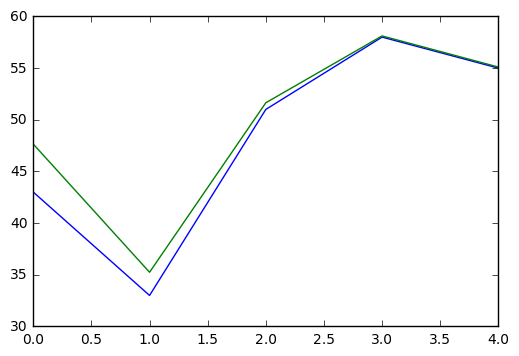

In [73]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[:,-1], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[:,-1])
pyplot.plot(predictions)
pyplot.show()

Ha! This is too good. Using the training data as the test data has caught up with me. Next time, I'll have to actually segregate the two.